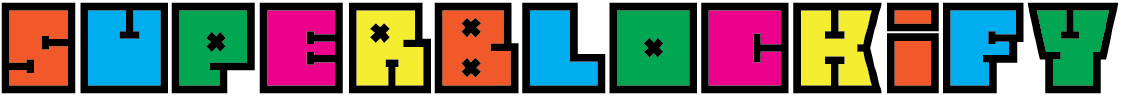

More info: [superblockify.city](https://superblockify.city)

# Population density

This notebook calculates population density, parametrized to work globally for any place.
This is split up into two parts:

1. Get the boundary for each place and calculate its area.
2. Find the enclosed population and divide by the area.

On the way, we will also touch upon resampling, raster data, and affine transformations.

As an example, we will use Bogotá, Colombia. First, we need to get the boundary
(multi)polygon.

In [ ]:
import io
import zipfile
from os.path import exists, basename

import matplotlib.pyplot as plt
import osmnx as ox
import rasterio
import requests
from matplotlib.colors import SymLogNorm
from rasterio.plot import show
from rasterio.windows import Window
from rasterio.enums import Resampling
from rasterstats import zonal_stats

## 1. Area Boundary

In [ ]:
bogota_gdf = ox.geocode_to_gdf('Bogotá, Colombia')
# Project to UTM, so we can treat it as flat Cartesian coordinates (meters)
bogota_gdf = ox.project_gdf(bogota_gdf)
print(f"The area of Bogotá is {round(bogota_gdf.area[0] / 10 ** 6, 2)} km²")
bogota_gdf.explore()

In [ ]:
bogota_multipolygon = bogota_gdf.geometry.unary_union

In [ ]:
bogota_multipolygon

## 2. Population

For a general solution, we want to be able to query the population dataset
(GHS-POP R2023A[^1]) for any place. We do not want to load the whole dataset,
so we will find out the bounding box of the place and only load the
raster data for that area.
To get an idea of the dataset structure, the
[download page](https://ghsl.jrc.ec.europa.eu/download.php) has a visualization of
the tiling. There is also an
[Interactive visualisation of the GHS population grid (R2023)](https://ghsl.jrc.ec.europa.eu/visualisation.php#lnlt=@50,15,4z&v=301&ln=0&gr=ds&lv=00000000000000100000000000000000000000011111&lo=aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa&pg=V).

All different GHSL datasets are available on the FTP server
[`https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/`](https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/)
and the 2023 population dataset is in the folder
[`GHS_POP_GLOBE_R2023A`](https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/).
The dataset is available in 5-year intervals and in resolutions of 100m, 1km, 3
arcsec, and 30 arcsec. We are interested in the 100m 2025 projection data.
The files are under
`https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2025_GLOBE_R2023A_54009_100/V1-0/tiles/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R{row}_C{col}.zip`,
where `row` and `col` are the row and column of the raster tile.
Each tile is 100km x 100km (row 1 to 18, column 1 to 36).
The whole dataset is in World Mollweide (ESRI:54009) projection (with the prime
meridian at Greenwich (EPSG:4326)) for the 100m and 1km resolution, and in WGS84
(EPSG:4326) for the 3 and 30 arcsec resolutions.

Another option is to directly download the whole dataset
[`/V1-0/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0.zip`](https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2025_GLOBE_R2023A_54009_100/V1-0/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0.zip).
In 100m resolution, the file is 4.9 GB (compressed). This way, we do not need to worry
about the tiling.


[^1]: Schiavina, M., Freire, S. & MacManus, K. GHS-POP R2023A - GHS population grid
multitemporal (1975-2030). (2023)
[doi:10.2905/2FF68A52-5B5B-4A22-8F40-C41DA8332CFE](https://doi.org/10.2905/2FF68A52-5B5B-4A22-8F40-C41DA8332CFE).

In [ ]:
def get_GHSL_urls(bbox_moll):
    """Get the URLs of the GHSL population raster tiles that contain the
    boundary.

    100m resolution, 2025 projection, World Mollweide projection.

    Parameters
    ----------
    bbox_moll : list
        Boundary of the place in Mollweide projection.
        [minx, miny, maxx, maxy]
    """
    corners = [
        (bbox_moll[0], bbox_moll[1]),  # southwest
        (bbox_moll[0], bbox_moll[3]),  # northwest
        (bbox_moll[2], bbox_moll[1]),  # southeast
        (bbox_moll[2], bbox_moll[3]),  # northeast
    ]
    # Empty set of URLs
    urls = set()
    # Check what tile(s) the boundary corners are in
    for corner in corners:
        # Get the row and column of the tile
        row = int((9000000 - corner[1]) / 1e6) + 1
        col = min(int((18041000 + corner[0]) / 1e6) + 1, 36)
        # Get the URL of the tile
        url = (
            f"https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL"
            f"/GHS_POP_GLOBE_R2023A/GHS_POP_E2025_GLOBE_R2023A_54009_100/V1-0/tiles/"
            f"GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R{row}_C{col}.zip"
        )
        # Add the URL to the set of URLs
        urls.add(url)
    return list(urls)

Load the whole tile of Bogotá in 100m resolution to get an idea of the data.

In [ ]:
# Project to World Mollweide to get the tile urls
bogota_gdf = bogota_gdf.to_crs("World Mollweide")
bogota_bbox = list(bogota_gdf.bounds.values[0])
bogota_url = get_GHSL_urls(bogota_bbox)

In [ ]:
def download_GHSL(urls):
    """Download the GHSL population raster tile.

    Parameters
    ----------
    urls : str or list
        URL(s) of the raster tile(s).

    Returns
    -------
    str or list
        Path(s) to the downloaded raster tile(s).
    """
    files = []
    for url in urls if isinstance(urls, (list, tuple)) else [urls]:
        # Check if file already exists - same as url but without the path and .tif
        if exists(basename(url)[:-4]+".tif"):
            files.append(basename(url)[:-4]+".tif")
            continue
        # Download zip file
        r = requests.get(url)
        # Unzip to working directory
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()  # zip includes tif, meta and data report
        # append file ending in .tif from z.namelist()
        files.append([f for f in z.namelist() if f.endswith(".tif")][0])
    return files[0] if len(files) == 1 else files

In [ ]:
# Download tile of the data for the area of Bogotá
file_colombia = download_GHSL(urls=bogota_url)
file_colombia

### Windowed Loading

As we do not want to always load the whole tile, we will load a window of the raster
determined by the bounding box of Bogotá.
Additionally, to that data subset, an affine transformation is needed to
address the coordinates.
The affine transformation is used to transform the raster coordinates to the
projection coordinates, and basically work like a `linspace` function.
It specifies step length in x and y direction, and the starting point (Northings
and Eastings).
The last column is `[0, 0, 1]`, because there is no rotation. Note that there is also
no shear.

Labelled affine transformation:
$$
\begin{bmatrix}
    x_{\text{step}} & 0 & x_{\text{start}} \\
    0 & y_{\text{step}} & y_{\text{start}} \\
    0 & 0 & 1
\end{bmatrix}
$$

### Resampling the Population

In our application, the areas of interests are neighborhoods, the size
of the polygons might in some cases be not much larger than the resolution of the
raster. The rasterization strategy can be to include all pixels that are fully
covered by the polygon, or to include all pixels that are at least partially
covered. For a relatively small polygon, there can be a difference in the
chosen strategy. Up-scaling the population raster can help to mitigate this.

An illustration of this effect[^2]:
![rasterization](../docs/_static/rasterization.png)
[^2]: [Rasterization strategies](https://pythonhosted.org/rasterstats/manual.html#rasterization-strategy)
rasterstats documentation.

A definitive resampling strategy does not exist; the only important consideration
is that the sum of the population is conserved.
One such approach is to homogeneously distribute the population over the pixels.
When splitting each pixel into :math:`n \times n` sub-pixels, the population becomes
:math:`P_{\mathrm{new}} = P_{\mathrm{old}} n^{-2}`.
The affine transformation also needs to be adjusted.
$$
\begin{bmatrix}
    x_{\text{step}} \frac{n_{x,\text{old}}}{n_{x,\text{new}}} & 0 & x_{\text{start}} \\
    0 & y_{\text{step}} \frac{n_{y,\text{old}}}{n_{y,\text{new}}} & y_{\text{start}} \\
    0 & 0 & 1
\end{bmatrix}
$$

In [ ]:
def resample_load_window(file, resample_factor=1, window=None, res_stategy=Resampling
                    .average):
    """Load and resample a window of a raster file.

    Parameters
    -----------
    file : str
        Path to the raster file. It Can be a tile or the whole raster.
    resample_factor : float, optional
        Factor to resample the window by. Values > 1 increase the resolution
        of the raster, values < 1 decrease the resolution of the raster by that
        factor in each dimension.
    window : rasterio.windows.Window, optional
        Window of the raster to resample, by default None.
    res_stategy : rasterio.enums.Resampling, optional
        Resampling strategy, by default Resampling.average.

    Returns
    -------
    raster_rescaled : numpy.ndarray
        Resampled raster.
    res_affine : rasterio.Affine
        Affine transformation of the resampled raster.
    """
    with rasterio.open(file) as src:
        if window is None:
            window = src.window(*src.bounds)
        # Resample the window
        res_window = Window(window.col_off * resample_factor,
                            window.row_off * resample_factor,
                            window.width * resample_factor,
                            window.height * resample_factor)
        # Read the raster while resampling
        raster_rescaled = src.read(
            1,
            out_shape=(1, int(res_window.height), int(res_window.width)),
            resampling=res_stategy,
            window=window,
            masked=True,
            boundless=True,
            fill_value=0,
        )

        # Affine transformation - respects the resampling
        res_affine = src.window_transform(window) * src.transform.scale(1 /
                                                                        resample_factor)

    return raster_rescaled, res_affine

To demonstrate the functionality up until now, we will load the population raster two
times. Once the whole raster tile, but downscaled by a factor of 10. We do not need
the full resolution for the whole tile, and it would take too long to load.
Secondly, we will load a window of the raster, unscaled.

In [ ]:
def plot_tile_and_boundary(pop_file, boundary_gdf):
    """Plot the population raster tile and the boundary.
    Only works for places in single tile."""
    pop_raster_downsampled, affine = resample_load_window(pop_file, 1/10,
                                                   res_stategy=Resampling.average)
    pop_raster_downsampled = pop_raster_downsampled / (1/10)**2  # for population conservation
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), width_ratios=[2, 1])
    show(pop_raster_downsampled, ax=axes[0], norm=SymLogNorm(linthresh=5,
                                                             linscale=1), transform=affine)
    cbar = fig.colorbar(axes[0].get_images()[0], ax=axes[0])
    cbar.ax.set_ylabel("Population per pixel")
    axes[0].set_title("Population around Bogotá")
    # Zoom in to Bogotá - linear scale
    with rasterio.open(pop_file) as src:
        window = src.window(*boundary_gdf.buffer(1000).total_bounds)
    pop_raster_zoom, affine = resample_load_window(pop_file, window=window)
    show(pop_raster_zoom, ax=axes[1], transform=affine)
    cbar = fig.colorbar(axes[1].get_images()[0], ax=axes[1])
    cbar.ax.set_ylabel("Population per pixel")
    boundary_gdf.boundary.plot(ax=axes[1], color="white")
    axes[1].set_xlim(boundary_gdf.total_bounds[0], boundary_gdf.total_bounds[2])
    axes[1].set_ylim(boundary_gdf.total_bounds[1], boundary_gdf.total_bounds[3])
    axes[1].set_title("Bogotá, Colombia")
    plt.tight_layout()
    plt.show()

plot_tile_and_boundary(file_colombia, bogota_gdf)

In the whole tile we can see Bogotá as the largest urban area. Other than that,
there is Santiago de Cali in the south-west of Bogotá, Medellín in the north-west,
and further north-east Bucaramanga, Cúcuta, and San Cristóbal (Venezuela).

In [ ]:
# Just in testing notebook, not for resources
# Testing the up-scaling with zoomed plot
resample_factor = 2/1
with rasterio.open(file_colombia) as src:
    window = src.window(*bogota_gdf.buffer(100).total_bounds)
pop_raster_zoom, affine_zoom = resample_load_window(
    file_colombia,
    window=window,
    resample_factor=resample_factor,
    res_stategy=Resampling.nearest
)
pop_raster_zoom = pop_raster_zoom / resample_factor**2

fig, ax = plt.subplots(figsize=(6, 6))
# plt.imshow(bogota_pop_raster, norm=SymLogNorm(linthresh=1, linscale=1))
show(pop_raster_zoom, transform=affine_zoom, norm=SymLogNorm(linthresh=1,
                                                            linscale=1), ax=ax)
z = 20
xdiff = bogota_gdf.total_bounds[2] - bogota_gdf.total_bounds[0]
ydiff = bogota_gdf.total_bounds[3] - bogota_gdf.total_bounds[1]
ax.set_xlim(bogota_gdf.total_bounds[0] + xdiff * (1/2 - z/100),
            bogota_gdf.total_bounds[2] - xdiff * (1/2 - z/100))
ax.set_ylim(bogota_gdf.total_bounds[1] + ydiff * (1/2 - z/200),
            bogota_gdf.total_bounds[3] - ydiff * (1/2 - z/200))
ax.set_title("Bogotá, Colombia")
plt.show()

### Population Summation

To sum up the population under a polygon, while respecting the population density,
we use the `zonal_stats` function from the `rasterstats` package.
We can use the `resample_load_window` function to load the raster for the polygon,
possibly upscaled, and then use `zonal_stats` to sum up the population.

In [ ]:
zs_bogota = zonal_stats(bogota_gdf, pop_raster_zoom, affine=affine_zoom,
                        stats="sum", nodata=0)
zs_bogota

In [ ]:
file_all = "../../data/ghsl/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0.tif"

resample_factor = 2

with rasterio.open(file_all) as src:
    window = src.window(*bogota_gdf.buffer(100).total_bounds)

pop_raster_zoom, affine_zoom = resample_load_window(
    file_all,
    window=window,
    resample_factor=resample_factor,
    res_stategy=Resampling.nearest
)
pop_raster_zoom = pop_raster_zoom / resample_factor**2

zonal_stats(bogota_gdf, pop_raster_zoom, affine=affine_zoom,
                        stats="sum", nodata=0)

The urban population of Bogotá about 8 million, the metropolitan area has
10 million inhabitants[^3]. This is a fitting result.

Finally, we want to write a function that takes a polygon of a place as a
GeoDataFrame, the population raster file, and a resample factor, and returns
the population of the place.

[^3]: Colaboradores de Wikipedia. Bogotá [en línea]. Wikipedia, La enciclopedia libre, 2023 [fecha de consulta: 4 de junio del 2023]. Disponible en <https://es.wikipedia.org/w/index.php?title=Bogot%C3%A1&oldid=151625853>.

In [ ]:
def get_population(place_gdf, pop_raster_file, resample_factor=1):
    """Get the population for a place.

    Parameters
    ----------
    place_gdf : GeoDataFrame
        GeoDataFrame of the place.
    pop_raster_file : str or list
        Path to the population raster file(s).
    resample_factor : float, optional
        Factor to resample the raster by. The default is 1. Optimally an integer for
        up-scaling.

    Returns
    -------
    float
        Population of the place.
    """
    # Window of place, buffered by 100m
    with rasterio.open(file_colombia) as src:
        window = src.window(*place_gdf.buffer(100).total_bounds)
        # Convert place to raster projection
        place_gdf_raster_crs = place_gdf.to_crs(src.crs.data)
    # Load population raster
    pop_raster, affine = resample_load_window(
        pop_raster_file, resample_factor, window=window,
        res_stategy=Resampling.nearest if resample_factor >= 1 else Resampling.average)
    pop_raster = pop_raster / resample_factor ** 2  # Correct for resampling

    # Get population
    zs_place = zonal_stats(place_gdf_raster_crs, pop_raster, affine=affine,
                           stats="sum", nodata=0)
    # Plot population raster with place boundary
    _, axe = plt.subplots(figsize=(6, 6))
    show(pop_raster, ax=axe, transform=affine, norm=SymLogNorm(linthresh=10,
                                                               linscale=1))
    cbar = plt.colorbar(axe.get_images()[0], ax=axe)
    cbar.ax.set_ylabel("Population per pixel")
    place_gdf_raster_crs.boundary.plot(ax=axe, color="white")

    return zs_place[0]["sum"]

In [ ]:
# Get population of Bogotá
get_population(bogota_gdf, file_colombia)

This result differs a bit from the first one, as we do not use resampling in this
function. The difference is of numerical nature. For our application with small LTNs,
we need the up-scaling to get good estimates of the population in the LTNs.

### Places on tile edges

The `get_population` function works well for places that are fully contained
in one tile. However, for places that are on the edge of a tile, the function
will not work. As a solution, we resort to the simple approach of running the
function for each tile and summing it up.
One such example is the city of Jönköping in Sweden, it falls on two tiles.

In [ ]:
def get_population(place_gdf, pop_raster_files, resample_factor=1, place_name=None):
    """Get the population for a place.

    Parameters
    ----------
    place_gdf : GeoDataFrame
        GeoDataFrame of the place.
    pop_raster_files : str or list
        Path to the population raster file(s).
    resample_factor : float, optional
        Factor to resample the raster by. The default is 1. Optimally an integer for
        up-scaling.
    place_name : str, optional
        Name of the place. The default is None.

    Returns
    -------
    float
        Population of the place.
    """
    fig, axe = plt.subplots(figsize=(6, 6))
    pop_sum = 0
    for pop_raster_file in pop_raster_files if isinstance(pop_raster_files, list) else [pop_raster_files]:
        # Window of place, buffered by 100m
        with rasterio.open(pop_raster_file) as src:
            window = src.window(*place_gdf.buffer(100).total_bounds)
            # Convert place to raster projection
            place_gdf_raster_crs = place_gdf.to_crs(src.crs.data)
            # Cut off window to raster extent - for the case of places on the edge of a tile
            window = window.intersection(src.window(*src.bounds))
        # Load population raster
        pop_raster, affine = resample_load_window(
            pop_raster_file, resample_factor, window=window,
            res_stategy=Resampling.nearest if resample_factor >= 1 else Resampling.average)
        pop_raster = pop_raster / resample_factor ** 2  # Correct for resampling
        # Set masked values to 0
        pop_raster = pop_raster.filled(0)
        # Get population
        zs_place = zonal_stats(place_gdf_raster_crs, pop_raster, affine=affine,
                               stats="sum", nodata=0)
        pop_sum += zs_place[0]["sum"]
        # Plot population raster with place boundary
        show(pop_raster, ax=axe, transform=affine, norm=SymLogNorm(linthresh=5,
                                                                   linscale=1))

    cbar = plt.colorbar(axe.get_images()[0], ax=axe)
    cbar.ax.set_ylabel("Population per pixel")
    place_gdf_raster_crs.boundary.plot(ax=axe, color="white")
    if place_name:
        fig.suptitle(place_name)
    # title with population
    axe.set_title(f"Population: {pop_sum:.0f}")
    plt.tight_layout()
    plt.show()
    return pop_sum

In [ ]:
def get_population_from_query(query):
    place_gdf = ox.geocode_to_gdf(query)
    place_gdf = place_gdf.to_crs("World Mollweide")
    place_url = get_GHSL_urls(list(place_gdf.bounds.values[0]))
    files_place = download_GHSL(urls=place_url)
    return get_population(place_gdf, files_place, place_name=query)

In [ ]:
# Get population of Jönköping
get_population_from_query("Jönköping, Sweden")

In [ ]:
# To find out a place with four tiles, show the grid points
import numpy as np
from shapely.geometry import Point
from geopandas import GeoDataFrame
y = np.arange(-80e5, 80e5, 10e5)
x = np.arange(-170.41e5, 170.59e5, 10e5)
# for ech point combination xy, check if is a valid World Molleweide coordinate
points = []
for i in range(len(y)):
    lat = np.arcsin(y[i] / 6371000) * 180 / np.pi
    for j in range(len(x)):
        lon = x[j] / (6371000 * np.cos(lat * np.pi / 180)) * 180 / np.pi
        if np.isnan(lon) == False and np.isnan(lat) == False and 90 > lat > -90 and \
                170 > lon > -170:
            points.append(Point(x[j], y[i]))
points_gdf = GeoDataFrame(geometry=points, crs="World Mollweide")
points_gdf.explore()

To have an example on an intersection of four tiles, we use the city of
Pontianak, West Kalimantan, Indonesia.

In [ ]:
get_population_from_query("Pontianak, West Kalimantan, Indonesia")

## Comparison

To test the approach, we want to compare several places with official population
data. Comparison data is taken from the
[World Population Review](https://worldpopulationreview.com/world-cities), which
sources from the [United Nations population estimates](https://esa.un.org/unpd/wup/).

In [ ]:
cities = [
    ["Delhi", "India", 32941308],
    ["Dhaka", "Bangladesh", 23209616],
    ["Cairo", "Egypt", 22183200],
    ["Seoul", "South Korea", 9988049],
    ["Alexandria", "Egypt", 5588477],
    ["Ankara", "Turkey", 5397098],
    ["Kiev", "Ukraine", 3016789],
    ["Port Au Prince", "Haiti", 2987455],
    ["Beirut", "Lebanon", 2421354],
    ["Naples", "Italy", 2179384],
    ["Frankfurt", "Germany", 796437]
]
for city in cities:
    print(f"{city[0]}, {city[1]}: {city[2]}")
    try:
        city.append(get_population_from_query(f"{city[0]}, {city[1]}"))
        # Append relative difference
        city.append((city[2] - city[3]) / city[2] * 100)
    except:
        cities.remove(city)

In [ ]:
import pandas as pd
#  Sort df after relative difference
df = pd.DataFrame(cities, columns=["city", "country", "population",
                                   "predicted_population", "rel_diff"])
display(df.sort_values(by="rel_diff"))

In [ ]:
plt.scatter(df["population"], df["rel_diff"])
plt.xscale("log")
plt.xlabel("Population")
plt.ylabel("Relative difference to predicition [%]")
plt.grid()
plt.show()

We see clear differences between the predicted and the official population.
More importantly, the predictions are always in the same order of magnitude.
The differences are due to the difference in character of the data sources.
While the official numbers are based on the governmental census, the predictions
might use a different border for the city, which is likely to cut off some, or
include some rural areas. Regarding this, the result is acceptable, especially
with the context that we will use it for small LTNs and only as a rough approximation
of the population and population density.